# Prerequisite
attention mechanism \
seq2seq

# 트랜스포머의 하이퍼 파라미터


dimension of embedding = 512    :     512차원을 갖는다 \
num_layers = 6 : 인코더 디코더를 얼마나 많이 쌓을 것인가 \
num_heads = 8 : 인코딩때 몇가징 시각으로 문제를 볼것인가



**트랜스포머가 등장한 이유** : seq2seq의 문제는 seq 길이가 길어지면 정보 손실이 일어나는 문제가 있다. 그렇다면 seq을 사용하지 않는 방법론을 생각하다가 enc-dec으로만 기존의 문제를 해결할 수 없을까라는 생각을 하였다. <br>
**seq2seq과 차이점** : seq은 t의 시간성을 가지는 구조였다면, transformer는 enc-dec구조가 n개 있다는 점이 차별점이다. 논문에서는 6개의 enc-dec를 사용하였다.


## 1. 포지셔날 인코딩
seq모델과는 다르게 시간성이 없어진 모델이다. 그렇다면 단어들간의 시간성, 순서성을 어떻게 넣어줄까? <br>
=> 포지셔날 인코딩이라는 개념을 사용하였다. <br>

구체적으로 방법론을 이야기 하자면, word embedding후 positional encoding을 하였다. <br>
<br>
$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

여기서 pos는 몇번째 단어인지, i는 몇번째 embedding인지, dmodel은 embedding의 차원수 이다. <br>
이렇게 포지셔널 인코딩 값을 더하면 같은 단어라도 문장내의 위치에 따라 벡터 값이 달라진다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        '''
        클래스의 인자로 포지션과, 임베딩 차원의 크기를 받는다.
        '''
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        '''sin,cos을 하기전 computations'''
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
                position = tf.range(position, dtype=tf.float32)[:, tf.newaxis], # 0,1,...,position with shape [position,1]
                i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],         # 0,1,...,dim with shape [1, dim]
                d_model = d_model)
                # returning [position, dim] metrix b/c broadcasting
        
        
        # emb-dim배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # emb-dim배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])


        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)       # numpy array -> tensorflow tensor
        pos_encoding = pos_encoding[tf.newaxis, ...] # [position, dim] => [1, position, dim]  // b/c input shape is 3d tensor

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## Positional Encoding을 시각화 해보자

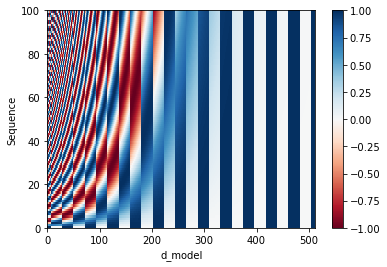

In [6]:
test_pos_encoding = PositionalEncoding(100, 512)
plt.pcolormesh(test_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Sequence')
plt.colorbar()
plt.show()

## attention 식
어텐션은 기본적으로 query, key, value를 받는다. 닷 프러덕트나, 바나다우 어텐션에서는 query에 decoder의 state이 들어가고, key,value에 인코딩에서 결과적으로 나온 latent vector가 들어간다. 하지만 트렌스포머에서는 seq개념을 안쓰므로 query에 decoder의 state이 안들어간다. 당시 좋은 성능을 보인 어텐션을 쓰고 싶엇던것으로 보이고(?), 셀프 어텐션이라는 개념이 등장한다. <br>
**셀프 어텐션**은 인코더에서 서로간의 관계성을 파악한다. query, key, value가 모두 encoder에서 발생한다. <br>
$Attention|(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $

In [13]:
pos = tf.range(10, dtype = tf.float32)[:, tf.newaxis]
i = tf.range(3, dtype = tf.float32)[tf.newaxis, :]

In [21]:
pre = 1/tf.pow(10000, (2*(i//2))/tf.cast(3, dtype=tf.float32))

In [22]:
pre

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.        , 1.        , 0.00215443]], dtype=float32)>

In [23]:
pos

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
       [8.],
       [9.]], dtype=float32)>

In [25]:
new = pre*pos
new[tf.newaxis, ...].shape

<tf.Tensor: shape=(1, 10, 3), dtype=float32, numpy=
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 1.0000000e+00, 2.1544343e-03],
        [2.0000000e+00, 2.0000000e+00, 4.3088687e-03],
        [3.0000000e+00, 3.0000000e+00, 6.4633032e-03],
        [4.0000000e+00, 4.0000000e+00, 8.6177373e-03],
        [5.0000000e+00, 5.0000000e+00, 1.0772171e-02],
        [6.0000000e+00, 6.0000000e+00, 1.2926606e-02],
        [7.0000000e+00, 7.0000000e+00, 1.5081041e-02],
        [8.0000000e+00, 8.0000000e+00, 1.7235475e-02],
        [9.0000000e+00, 9.0000000e+00, 1.9389909e-02]]], dtype=float32)>

In [26]:
new

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.0000000e+00, 2.1544343e-03],
       [2.0000000e+00, 2.0000000e+00, 4.3088687e-03],
       [3.0000000e+00, 3.0000000e+00, 6.4633032e-03],
       [4.0000000e+00, 4.0000000e+00, 8.6177373e-03],
       [5.0000000e+00, 5.0000000e+00, 1.0772171e-02],
       [6.0000000e+00, 6.0000000e+00, 1.2926606e-02],
       [7.0000000e+00, 7.0000000e+00, 1.5081041e-02],
       [8.0000000e+00, 8.0000000e+00, 1.7235475e-02],
       [9.0000000e+00, 9.0000000e+00, 1.9389909e-02]], dtype=float32)>